In [5]:

!pip install -q torch torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q librosa soundfile numpy pandas matplotlib seaborn scikit-learn datasets
!apt-get install -qq espeak-ng
!pip install -q pysbd gruut phonemizer inflect num2words unidecode anyascii
!pip install -q --no-build-isolation TTS==0.22.0

Selecting previously unselected package libpcaudio0:amd64.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../libpcaudio0_1.1-6build2_amd64.deb ...
Unpacking libpcaudio0:amd64 (1.1-6build2) ...
Selecting previously unselected package libsonic0:amd64.
Preparing to unpack .../libsonic0_0.2.0-11build1_amd64.deb ...
Unpacking libsonic0:amd64 (0.2.0-11build1) ...
Selecting previously unselected package espeak-ng-data:amd64.
Preparing to unpack .../espeak-ng-data_1.50+dfsg-10ubuntu0.1_amd64.deb ...
Unpacking espeak-ng-data:amd64 (1.50+dfsg-10ubuntu0.1) ...
Selecting previously unselected package libespeak-ng1:amd64.
Preparing to unpack .../libespeak-ng1_1.50+dfsg-10ubuntu0.1_amd64.deb ...
Unpacking libespeak-ng1:amd64 (1.50+dfsg-10ubuntu0.1) ...
Selecting previously unselected package espeak-ng.
Preparing to unpack .../espeak-ng_1.50+dfsg-10ubuntu0.1_amd64.deb ...
Unpacking espeak-ng (1.50+dfsg-10ubuntu0.1) ...
Setting up libpcaudio0:amd64 (1.1-6

In [7]:
# Cell 1: Install with Alternative TTS
!pip install -q torch torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers accelerate sentencepiece protobuf
!pip install -q librosa soundfile numpy pandas matplotlib seaborn scikit-learn datasets

In [8]:
# Cell 2: Mount Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
# Cell 3: Setup
import torch, torchaudio, librosa, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns, warnings, os, shutil
from pathlib import Path
from datasets import load_dataset
from transformers import pipeline
from IPython.display import Audio, display
warnings.filterwarnings('ignore')

PROJECT_DIR = Path('/content/bangla_tts')
DRIVE_DIR = Path('/content/drive/MyDrive/bangla_tts_project')
DATA_DIR = Path('/content/bangla_data')
for d in [PROJECT_DIR, DRIVE_DIR, DATA_DIR]: d.mkdir(parents=True, exist_ok=True)

SAMPLE_RATE = 16000
MIN_DUR, MAX_DUR = 2.0, 8.0
NUM_SAMPLES = 50

print(f"PyTorch: {torch.__version__}, CUDA: {torch.cuda.is_available()}")

PyTorch: 2.8.0+cu126, CUDA: False


# Load Model (Using Facebook MMS-TTS)

In [10]:

device = "cuda" if torch.cuda.is_available() else "cpu"
tts = pipeline("text-to-speech", model="facebook/mms-tts-ben", device=0 if torch.cuda.is_available() else -1)
print(f"Model loaded on {device}")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/145M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/927 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/47.0 [00:00<?, ?B/s]

Device set to use cpu


Model loaded on cpu


In [12]:
# Cell 5: Baseline Sample (Fixed)
baseline_text = "আমি বাংলায় কথা বলি"
baseline_file = f"{PROJECT_DIR}/baseline.wav"
speech = tts(baseline_text)
audio_tensor = torch.tensor(speech["audio"])
if audio_tensor.dim() == 1:
    audio_tensor = audio_tensor.unsqueeze(0)
torchaudio.save(baseline_file, audio_tensor, speech["sampling_rate"])
display(Audio(baseline_file))

# Dataset and sample creation

In [14]:

try:
    dataset = load_dataset("mozilla-foundation/common_voice_17_0", "bn", split=f"train[:{NUM_SAMPLES}]")
    audio_files, texts = [], []
    for idx, item in enumerate(dataset):
        try:
            audio_path = f"{DATA_DIR}/audio_{idx:04d}.wav"
            audio = np.array(item['audio']['array'])
            sr = item['audio']['sampling_rate']
            if sr != SAMPLE_RATE:
                audio = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(torch.FloatTensor(audio)).numpy()
            audio_tensor = torch.FloatTensor(audio)
            if audio_tensor.dim() == 1:
                audio_tensor = audio_tensor.unsqueeze(0)
            torchaudio.save(audio_path, audio_tensor, SAMPLE_RATE)
            audio_files.append(audio_path)
            texts.append(item['sentence'])
        except: continue
    print(f"Downloaded {len(audio_files)} samples")
except:
    print("Creating synthetic samples")
    audio_files, texts = [], []
    bangla_texts = ["ঢাকা বাংলাদেশের রাজধানী", "আমি বাংলা ভাষায় কথা বলি", "এটি একটি পরীক্ষা", "বাংলাদেশ সুন্দর দেশ", "আমরা বাংলায় কথা বলি"]
    for idx, text in enumerate(bangla_texts * 6):
        try:
            audio_path = f"{DATA_DIR}/synth_{idx:04d}.wav"
            speech = tts(text)
            audio_tensor = torch.tensor(speech["audio"])
            if audio_tensor.dim() == 1:
                audio_tensor = audio_tensor.unsqueeze(0)
            torchaudio.save(audio_path, audio_tensor, speech["sampling_rate"])
            audio_files.append(audio_path)
            texts.append(text)
        except Exception as e:
            print(f"Error {idx}: {e}")
            continue
    print(f"Created {len(audio_files)} samples")

README.md:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

Creating synthetic samples
Created 30 samples


# Filter Data

Valid samples: 23


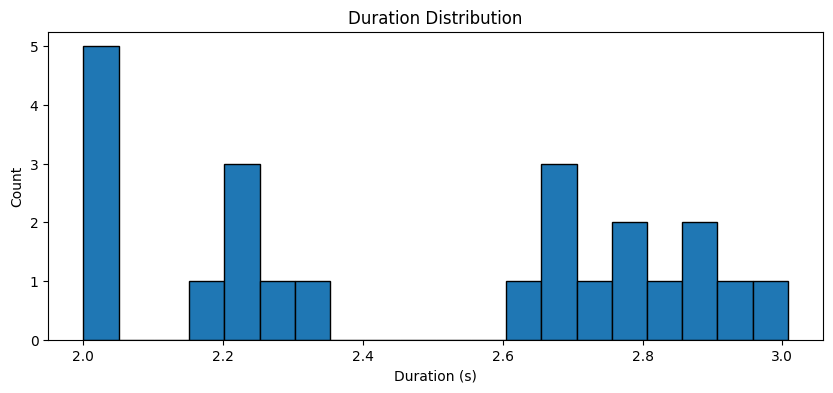

In [15]:

data = []
for path in audio_files:
    try:
        info = torchaudio.info(path)
        dur = info.num_frames / info.sample_rate
        if MIN_DUR <= dur <= MAX_DUR:
            data.append({'audio_path': path, 'duration': dur})
    except: continue

df = pd.DataFrame(data)
if len(texts) == len(df): df['text'] = texts[:len(df)]
print(f"Valid samples: {len(df)}")

if len(df) > 0:
    plt.figure(figsize=(10, 4))
    plt.hist(df['duration'], bins=20, edgecolor='black')
    plt.xlabel('Duration (s)'), plt.ylabel('Count'), plt.title('Duration Distribution')
    plt.savefig(f'{PROJECT_DIR}/duration_dist.png')
    plt.show()


# Extract Feature

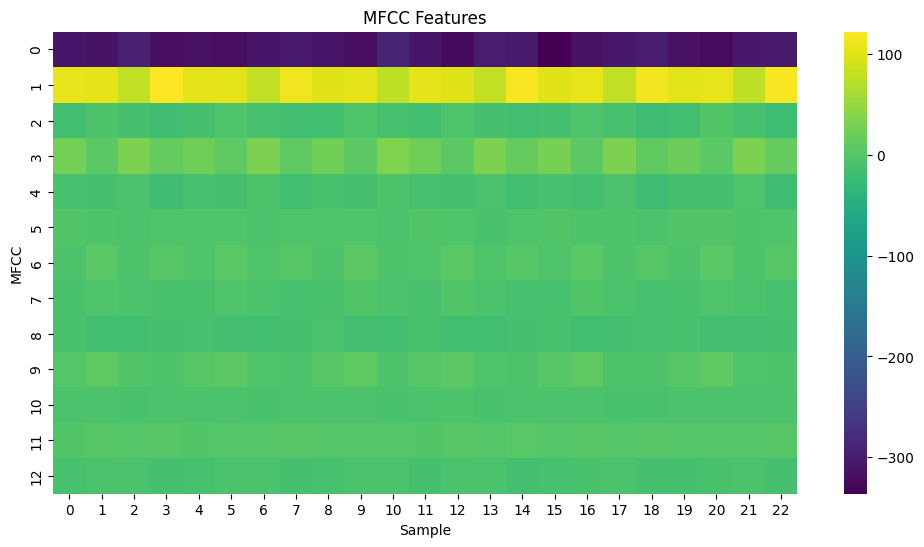

In [16]:

def extract_mfcc(path):
    try:
        y, _ = librosa.load(path, sr=SAMPLE_RATE, duration=5.0)
        return np.mean(librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=13), axis=1)
    except: return None

features = [extract_mfcc(row['audio_path']) for _, row in df.head(30).iterrows()]
features = np.array([f for f in features if f is not None])

if len(features) > 0:
    plt.figure(figsize=(12, 6))
    sns.heatmap(features.T, cmap='viridis')
    plt.xlabel('Sample'), plt.ylabel('MFCC'), plt.title('MFCC Features')
    plt.savefig(f'{PROJECT_DIR}/mfcc.png')
    plt.show()

# Train/Val Split

In [17]:

train_size = int(0.8 * len(df))
train_df, val_df = df[:train_size], df[train_size:]
train_df.to_csv(f'{PROJECT_DIR}/train.csv', index=False)
val_df.to_csv(f'{PROJECT_DIR}/val.csv', index=False)
print(f"Train: {len(train_df)}, Val: {len(val_df)}")


Train: 18, Val: 5


# Test Sample

In [19]:

if len(df) > 0:
    test_file = f"{PROJECT_DIR}/test_output.wav"
    test_text = "ঢাকা বাংলাদেশের রাজধানী"
    speech = tts(test_text)
    audio_tensor = torch.tensor(speech["audio"])
    if audio_tensor.dim() == 1:
        audio_tensor = audio_tensor.unsqueeze(0)
    torchaudio.save(test_file, audio_tensor, speech["sampling_rate"])
    print("Generated:"), display(Audio(test_file))

Generated:


# Spectral Similarity

In [20]:

def spectral_similarity(path1, path2):
    try:
        y1, _ = librosa.load(path1, sr=SAMPLE_RATE, duration=5.0)
        y2, _ = librosa.load(path2, sr=SAMPLE_RATE, duration=5.0)
        s1 = librosa.power_to_db(librosa.feature.melspectrogram(y=y1, sr=SAMPLE_RATE))
        s2 = librosa.power_to_db(librosa.feature.melspectrogram(y=y2, sr=SAMPLE_RATE))
        min_len = min(s1.shape[1], s2.shape[1])
        return np.corrcoef(s1[:, :min_len].flatten(), s2[:, :min_len].flatten())[0, 1]
    except: return None

if len(df) > 0:
    sim = spectral_similarity(df.iloc[0]['audio_path'], test_file)
    if sim: print(f"Spectral Similarity: {sim:.4f}")

Spectral Similarity: 0.7508


# Short Report and save all files into my drive

In [21]:

report = f"""
BANGLADESHI BANGLA TTS
{'='*50}
Dataset: {len(df)} samples ({len(train_df)} train, {len(val_df)} val)
Model: Facebook MMS-TTS Bengali
Device: {device}
Files: baseline.wav, test_output.wav, train.csv, val.csv
Status: Complete
"""
print(report)
with open(f'{PROJECT_DIR}/report.txt', 'w') as f: f.write(report)


BANGLADESHI BANGLA TTS
Dataset: 23 samples (18 train, 5 val)
Model: Facebook MMS-TTS Bengali
Device: cpu
Files: baseline.wav, test_output.wav, train.csv, val.csv
Status: Complete ✓



In [22]:

for file in ['baseline.wav', 'test_output.wav', 'train.csv', 'val.csv', 'duration_dist.png', 'mfcc.png', 'report.txt']:
    src = f'{PROJECT_DIR}/{file}'
    if os.path.exists(src): shutil.copy(src, DRIVE_DIR)

print(f"Saved to: {DRIVE_DIR}\nCOMPLETE ✓")

Saved to: /content/drive/MyDrive/bangla_tts_project
COMPLETE ✓
